# OCT B-scan Annotation Visualization

This notebook provides tools to visualize OCT B-scan images with layer annotations from our Hybrid Attention U-Net model. It includes functions to plot ground truth and predicted ILM/BM layer boundaries with comprehensive visualization capabilities.

## Model Information
- **Model**: Hybrid Attention U-Net for OCT Layer Segmentation
- **Training Run**: runs/hybrid_unet_20250917_214714
- **Architecture**: Attention-based U-Net with edge and spatial attention mechanisms
- **Classes**: 3-class segmentation (Above ILM, ILM-BM, Below BM)

In [1]:
# Import Required Libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import h5py
import yaml
import json
import torch
import torch.nn.functional as F
from PIL import Image
import cv2
from typing import Dict, List, Tuple, Optional, Any

# Add source directory to path for model imports
sys.path.append('scr')

# Set matplotlib parameters for better visualization
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

print("✓ All libraries imported successfully")
print("✓ Matplotlib configured for OCT visualization")

✓ All libraries imported successfully
✓ Matplotlib configured for OCT visualization


In [3]:
# Load Model and Configuration
from model import HybridAttentionUNet

class ModelLoader:
    """Helper class to load trained model and configuration."""
    
    def __init__(self, run_path: str):
        self.run_path = run_path
        self.model = None
        self.config = None
        self.training_results = None
        
    def load_model(self, model_filename: str = "best_model.pth"):
        """Load the trained model with automatic architecture detection."""
        model_path = os.path.join(self.run_path, model_filename)
        
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found: {model_path}")
        
        # Load checkpoint
        checkpoint = torch.load(model_path, map_location='cpu')
        
        # Infer model architecture from saved weights (more robust approach)
        state_dict = checkpoint['model_state_dict']
        
        # Infer input channels from first conv layer
        in_channels = state_dict['encoder1.conv_block.0.weight'].shape[1]
        
        # Infer base channels from first conv layer output
        base_channels = state_dict['encoder1.conv_block.0.weight'].shape[0]
        
        # Infer output channels from final conv layer
        out_channels = state_dict['final_conv.weight'].shape[0]
        
        print(f"🔍 Model architecture inferred from saved weights:")
        print(f"   Input channels: {in_channels}")
        print(f"   Base channels: {base_channels}")
        print(f"   Output channels: {out_channels}")
        
        # Create model with correct architecture
        self.model = HybridAttentionUNet(
            in_channels=in_channels,
            out_channels=out_channels,
            base_channels=base_channels
        )
        
        # Load model weights
        self.model.load_state_dict(state_dict)
        self.model.eval()
        
        print(f"✓ Model loaded from: {model_path}")
        print(f"✓ Training epoch: {checkpoint.get('epoch', 'unknown')}")
        
        return self.model
    
    def load_training_results(self):
        """Load training results and metadata."""
        results_files = [
            "training_results.json",
            "training_summary.json", 
            "final_inference_results.json"
        ]
        
        self.training_results = {}
        for filename in results_files:
            filepath = os.path.join(self.run_path, filename)
            if os.path.exists(filepath):
                with open(filepath, 'r') as f:
                    self.training_results[filename.replace('.json', '')] = json.load(f)
                print(f"✓ Loaded: {filename}")
        
        return self.training_results

# Initialize model loader with our training run
run_path = "runs/hybrid_unet_20250917_214714"
model_loader = ModelLoader(run_path)

# Load model and results
model = model_loader.load_model()
training_results = model_loader.load_training_results()

print(f"\n✅ Model loaded successfully from: {run_path}")
print(f"✅ Training results loaded: {list(training_results.keys())}")

🔍 Model architecture inferred from saved weights:
   Input channels: 1
   Base channels: 32
   Output channels: 3
✓ Model loaded from: runs/hybrid_unet_20250917_214714/best_model.pth
✓ Training epoch: 2
✓ Loaded: training_results.json
✓ Loaded: training_summary.json
✓ Loaded: final_inference_results.json

✅ Model loaded successfully from: runs/hybrid_unet_20250917_214714
✅ Training results loaded: ['training_results', 'training_summary', 'final_inference_results']


In [6]:
# Define Annotation Plotting Function

def mask_to_coordinates(mask: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert segmentation mask to ILM and BM coordinates.
    
    Args:
        mask: Segmentation mask of shape (H, W) with classes 0, 1, 2
        
    Returns:
        Tuple of (ilm_coords, bm_coords) each of shape (W,)
    """
    height, width = mask.shape
    ilm_coords = np.full(width, np.nan)
    bm_coords = np.full(width, np.nan)
    
    for x in range(width):
        column = mask[:, x]
        
        # Find ILM boundary (transition from class 0 to class 1)
        class_1_pixels = np.where(column == 1)[0]
        if len(class_1_pixels) > 0:
            ilm_coords[x] = class_1_pixels[0]
        
        # Find BM boundary (transition from class 1 to class 2)
        class_2_pixels = np.where(column == 2)[0]
        if len(class_2_pixels) > 0:
            bm_coords[x] = class_2_pixels[0]
    
    return ilm_coords, bm_coords

def plot_bscan_annotations(
    image: np.ndarray,
    gt_ilm: Optional[np.ndarray] = None,
    gt_bm: Optional[np.ndarray] = None,
    pred_ilm: Optional[np.ndarray] = None,
    pred_bm: Optional[np.ndarray] = None,
    pred_mask: Optional[np.ndarray] = None,
    title: str = "OCT B-scan with Layer Annotations",
    show_mask_overlay: bool = True,
    alpha_mask: float = 0.3,
    figsize: Tuple[int, int] = (15, 8)
) -> plt.Figure:
    """
    Plot B-scan image with layer annotations.
    
    Args:
        image: B-scan image of shape (H, W)
        gt_ilm: Ground truth ILM coordinates (W,)
        gt_bm: Ground truth BM coordinates (W,)
        pred_ilm: Predicted ILM coordinates (W,)
        pred_bm: Predicted BM coordinates (W,)
        pred_mask: Predicted segmentation mask (H, W)
        title: Plot title
        show_mask_overlay: Whether to show segmentation mask overlay
        alpha_mask: Transparency of mask overlay
        figsize: Figure size
        
    Returns:
        matplotlib Figure object
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Display B-scan image
    ax.imshow(image, cmap='gray', aspect='auto')
    
    # Create x-coordinates for plotting
    x_coords = np.arange(image.shape[1])
    
    # Plot ground truth annotations
    if gt_ilm is not None:
        valid_gt_ilm = ~np.isnan(gt_ilm)
        if np.any(valid_gt_ilm):
            ax.plot(x_coords[valid_gt_ilm], gt_ilm[valid_gt_ilm], 
                   'g-', linewidth=2, label='GT ILM', alpha=0.8)
    
    if gt_bm is not None:
        valid_gt_bm = ~np.isnan(gt_bm)
        if np.any(valid_gt_bm):
            ax.plot(x_coords[valid_gt_bm], gt_bm[valid_gt_bm], 
                   'b-', linewidth=2, label='GT BM', alpha=0.8)
    
    # Plot predicted annotations
    if pred_ilm is not None:
        valid_pred_ilm = ~np.isnan(pred_ilm)
        if np.any(valid_pred_ilm):
            ax.plot(x_coords[valid_pred_ilm], pred_ilm[valid_pred_ilm], 
                   'r--', linewidth=2, label='Pred ILM', alpha=0.8)
    
    if pred_bm is not None:
        valid_pred_bm = ~np.isnan(pred_bm)
        if np.any(valid_pred_bm):
            ax.plot(x_coords[valid_pred_bm], pred_bm[valid_pred_bm], 
                   'orange', linestyle='--', linewidth=2, label='Pred BM', alpha=0.8)
    
    # Show segmentation mask overlay
    if show_mask_overlay and pred_mask is not None:
        # Create colored mask overlay
        colors = ['black', 'red', 'blue']  # Classes 0, 1, 2
        cmap = ListedColormap(colors)
        
        # Create mask for overlay (only show non-background classes)
        overlay_mask = np.ma.masked_where(pred_mask == 0, pred_mask)
        ax.imshow(overlay_mask, cmap=cmap, alpha=alpha_mask, aspect='auto', vmin=0, vmax=2)
    
    # Formatting
    ax.set_xlabel('A-scan Index (Lateral Position)')
    ax.set_ylabel('Pixel Depth (Axial Position)')
    ax.set_title(title)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Invert y-axis to match OCT convention (depth increases downward)
    ax.invert_yaxis()
    
    plt.tight_layout()
    return fig

def plot_bscan_comparison_grid(
    images: List[np.ndarray],
    gt_ilm_list: List[np.ndarray],
    gt_bm_list: List[np.ndarray],
    pred_ilm_list: List[np.ndarray],
    pred_bm_list: List[np.ndarray],
    titles: Optional[List[str]] = None,
    figsize: Tuple[int, int] = (20, 12),
    cols: int = 2
) -> plt.Figure:
    """
    Plot multiple B-scans in a grid for comparison.
    
    Args:
        images: List of B-scan images
        gt_ilm_list: List of ground truth ILM coordinates
        gt_bm_list: List of ground truth BM coordinates
        pred_ilm_list: List of predicted ILM coordinates
        pred_bm_list: List of predicted BM coordinates
        titles: List of subplot titles
        figsize: Figure size
        cols: Number of columns in grid
        
    Returns:
        matplotlib Figure object
    """
    n_images = len(images)
    rows = (n_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(n_images):
        row, col = divmod(i, cols)
        ax = axes[row, col]
        
        # Plot B-scan
        ax.imshow(images[i], cmap='gray', aspect='auto')
        
        # Create x-coordinates
        x_coords = np.arange(images[i].shape[1])
        
        # Plot annotations
        if gt_ilm_list[i] is not None:
            valid_gt_ilm = ~np.isnan(gt_ilm_list[i])
            if np.any(valid_gt_ilm):
                ax.plot(x_coords[valid_gt_ilm], gt_ilm_list[i][valid_gt_ilm], 
                       'g-', linewidth=2, label='GT ILM', alpha=0.8)
        
        if gt_bm_list[i] is not None:
            valid_gt_bm = ~np.isnan(gt_bm_list[i])
            if np.any(valid_gt_bm):
                ax.plot(x_coords[valid_gt_bm], gt_bm_list[i][valid_gt_bm], 
                       'b-', linewidth=2, label='GT BM', alpha=0.8)
        
        if pred_ilm_list[i] is not None:
            valid_pred_ilm = ~np.isnan(pred_ilm_list[i])
            if np.any(valid_pred_ilm):
                ax.plot(x_coords[valid_pred_ilm], pred_ilm_list[i][valid_pred_ilm], 
                       'r--', linewidth=2, label='Pred ILM', alpha=0.8)
        
        if pred_bm_list[i] is not None:
            valid_pred_bm = ~np.isnan(pred_bm_list[i])
            if np.any(valid_pred_bm):
                ax.plot(x_coords[valid_pred_bm], pred_bm_list[i][valid_pred_bm], 
                       'orange', linestyle='--', linewidth=2, label='Pred BM', alpha=0.8)
        
        # Formatting
        ax.invert_yaxis()
        ax.set_xlabel('A-scan Index')
        ax.set_ylabel('Pixel Depth')
        if titles and i < len(titles):
            ax.set_title(titles[i])
        else:
            ax.set_title(f'B-scan {i+1}')
        
        if i == 0:  # Only show legend on first subplot
            ax.legend(loc='upper right', fontsize=10)
    
    # Hide empty subplots
    for i in range(n_images, rows * cols):
        row, col = divmod(i, cols)
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    return fig

print("✓ Annotation plotting functions defined successfully")
print("✓ Available functions:")
print("  - plot_bscan_annotations(): Single B-scan visualization")
print("  - plot_bscan_comparison_grid(): Multi B-scan comparison")
print("  - mask_to_coordinates(): Convert segmentation to coordinates")

✓ Annotation plotting functions defined successfully
✓ Available functions:
  - plot_bscan_annotations(): Single B-scan visualization
  - plot_bscan_comparison_grid(): Multi B-scan comparison
  - mask_to_coordinates(): Convert segmentation to coordinates


In [5]:
# Load B-scan Data and Inference Results

class DataLoader:
    """Helper class to load B-scan data and inference results."""
    
    def __init__(self, data_path: str = "data/Nemours_Jing_0805.h5"):
        self.data_path = data_path
        self.images = None
        self.ilm_coords = None
        self.bm_coords = None
        
    def load_original_data(self):
        """Load original B-scan images and annotations."""
        with h5py.File(self.data_path, 'r') as f:
            self.images = f['images'][:]  # Shape: (N, 496, 768)
            self.ilm_coords = f['layers']['ILM'][:]  # Shape: (N, 768)
            self.bm_coords = f['layers']['BM'][:]    # Shape: (N, 768)
        
        print(f"✓ Loaded original data from: {self.data_path}")
        print(f"✓ Images shape: {self.images.shape}")
        print(f"✓ ILM coords shape: {self.ilm_coords.shape}")
        print(f"✓ BM coords shape: {self.bm_coords.shape}")
        
        return self.images, self.ilm_coords, self.bm_coords
    
    def load_inference_results(self, inference_path: str):
        """Load pre-computed inference results from HDF5 file."""
        with h5py.File(inference_path, 'r') as f:
            # Load predictions using correct paths based on actual file structure
            pred_masks = f['prediction_masks'][:]
            pred_ilm = f['predicted_layers/ILM'][:]
            pred_bm = f['predicted_layers/BM'][:]
            confidence_maps = f['confidence_maps'][:]
            
            # Load ground truth data from inference file
            gt_ilm = f['layers/ILM'][:]
            gt_bm = f['layers/BM'][:]
            images = f['images'][:]
            
            print(f"✓ Loaded inference results from: {inference_path}")
            print(f"✓ Prediction masks shape: {pred_masks.shape}")
            print(f"✓ ILM predictions shape: {pred_ilm.shape}")
            print(f"✓ BM predictions shape: {pred_bm.shape}")
            print(f"✓ Confidence maps shape: {confidence_maps.shape}")
            print(f"✓ Test set images shape: {images.shape}")
            
            return {
                'masks': pred_masks,
                'ilm': pred_ilm,
                'bm': pred_bm,
                'confidence': confidence_maps,
                'gt_ilm': gt_ilm,
                'gt_bm': gt_bm,
                'images': images,
                'n_samples': len(images)
            }
    
    def preprocess_image(self, image: np.ndarray) -> np.ndarray:
        """Preprocess image for visualization (resize to 480x768)."""
        # Resize from (496, 768) to (480, 768)
        resized = cv2.resize(image, (768, 480), interpolation=cv2.INTER_LINEAR)
        
        # Apply preprocessing (CLAHE)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        processed = clahe.apply(resized.astype(np.uint8))
        
        # Normalize to [0, 1] for visualization
        normalized = processed.astype(np.float32) / 255.0
        
        return normalized
    
    def resize_coordinates(self, coords: np.ndarray, original_height: int = 496, target_height: int = 480) -> np.ndarray:
        """Resize coordinates to match target image size."""
        scale_factor = target_height / original_height
        resized_coords = coords.copy()
        
        valid_mask = ~np.isnan(resized_coords)
        resized_coords[valid_mask] *= scale_factor
        
        return resized_coords
    
    def prepare_visualization_data(self, inference_results: Dict, sample_indices: Optional[List[int]] = None) -> Dict:
        """Prepare data for visualization with ground truth and predictions."""
        if sample_indices is None:
            sample_indices = list(range(min(5, inference_results['n_samples'])))
        
        viz_data = {
            'indices': [],
            'processed_images': [],
            'gt_ilm': [],
            'gt_bm': [],
            'pred_masks': [],
            'pred_ilm': [],
            'pred_bm': [],
            'confidence': []
        }
        
        for i in sample_indices:
            if i >= inference_results['n_samples']:
                print(f"Warning: Index {i} out of range, skipping")
                continue
                
            # Get data from inference results (already preprocessed)
            original_img = inference_results['images'][i]
            gt_ilm = inference_results['gt_ilm'][i]
            gt_bm = inference_results['gt_bm'][i]
            
            # Preprocess original image for visualization
            processed_img = self.preprocess_image(original_img)
            
            # Resize ground truth coordinates to match processed image
            resized_gt_ilm = self.resize_coordinates(gt_ilm)
            resized_gt_bm = self.resize_coordinates(gt_bm)
            
            # Get predictions (already in correct size - 480x768)
            pred_mask = inference_results['masks'][i]
            pred_ilm = inference_results['ilm'][i]
            pred_bm = inference_results['bm'][i]
            confidence = inference_results['confidence'][i]
            
            # Store data
            viz_data['indices'].append(i)
            viz_data['processed_images'].append(processed_img)
            viz_data['gt_ilm'].append(resized_gt_ilm)
            viz_data['gt_bm'].append(resized_gt_bm)
            viz_data['pred_masks'].append(pred_mask)
            viz_data['pred_ilm'].append(pred_ilm)
            viz_data['pred_bm'].append(pred_bm)
            viz_data['confidence'].append(confidence)
        
        print(f"✓ Prepared visualization data for {len(viz_data['indices'])} samples")
        return viz_data

# Initialize data loader and load data
data_loader = DataLoader()
original_images, original_ilm, original_bm = data_loader.load_original_data()

# Load the most recent inference results
import glob
inference_files = glob.glob("runs/hybrid_unet_20250917_214714/test_predictions_*.h5")
if inference_files:
    latest_inference_file = max(inference_files, key=os.path.getctime)
    print(f"📁 Using latest inference file: {latest_inference_file}")
    
    # Load inference results
    inference_results = data_loader.load_inference_results(latest_inference_file)
    
    # Prepare visualization data for first 5 samples
    sample_indices = [0, 50, 100, 150, 200]  # Sample different positions
    viz_data = data_loader.prepare_visualization_data(inference_results, sample_indices)
    
    print(f"\n✅ Data loaded successfully!")
    print(f"✅ Original dataset: {len(original_images)} B-scans")
    print(f"✅ Inference results: {inference_results['n_samples']} predictions")
    print(f"✅ Visualization samples: {len(viz_data['indices'])} prepared")
    print(f"✅ Sample B-scan indices: {viz_data['indices']}")
else:
    print("❌ No inference results found! Please run inference first.")
    print("   Use: python inference.py --model_path runs/hybrid_unet_20250917_214714/best_model.pth")

✓ Loaded original data from: data/Nemours_Jing_0805.h5
✓ Images shape: (1266, 496, 768)
✓ ILM coords shape: (1266, 768)
✓ BM coords shape: (1266, 768)
📁 Using latest inference file: runs/hybrid_unet_20250917_214714/test_predictions_20250917_232332.h5
✓ Loaded inference results from: runs/hybrid_unet_20250917_214714/test_predictions_20250917_232332.h5
✓ Prediction masks shape: (254, 480, 768)
✓ ILM predictions shape: (254, 768)
✓ BM predictions shape: (254, 768)
✓ Confidence maps shape: (254, 480, 768)
✓ Test set images shape: (254, 496, 768)
✓ Prepared visualization data for 5 samples

✅ Data loaded successfully!
✅ Original dataset: 1266 B-scans
✅ Inference results: 254 predictions
✅ Visualization samples: 5 prepared
✅ Sample B-scan indices: [0, 50, 100, 150, 200]
✓ Loaded inference results from: runs/hybrid_unet_20250917_214714/test_predictions_20250917_232332.h5
✓ Prediction masks shape: (254, 480, 768)
✓ ILM predictions shape: (254, 768)
✓ BM predictions shape: (254, 768)
✓ Confiden

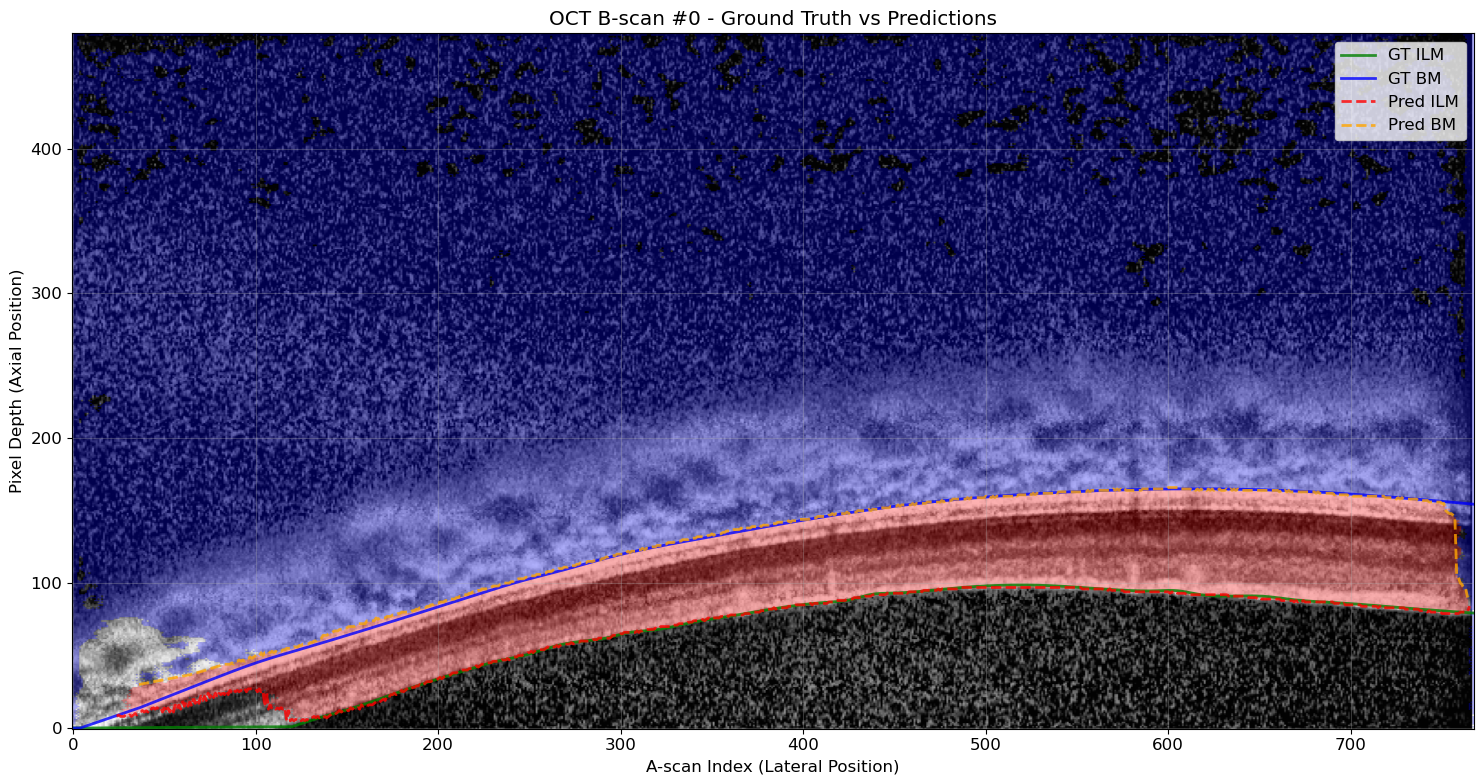


📊 Prediction Statistics for B-scan #0:
   Image size: (480, 768)
   GT ILM points: 653/768
   GT BM points: 737/768
   Pred ILM points: 742/768
   Pred BM points: 683/768
   ILM MAE: 0.70 pixels
   ILM RMSE: 0.93 pixels
   BM MAE: 1.98 pixels
   BM RMSE: 6.16 pixels

🎯 Segmentation Class Distribution:
   Class 0 (Above ILM): 65,893 pixels (17.9%)
   Class 1 (ILM-BM): 42,174 pixels (11.4%)
   Class 2 (Below BM): 260,573 pixels (70.7%)

🏆 Overall Model Performance (Test Set):
   Dice Score: 0.481
   IoU Score: 0.354
   ILM MAE: 30.74 pixels
   BM MAE: 3.64 pixels
   Overall MAE: 19.16 pixels
   ILM CCC: 0.861
   BM CCC: 0.994


In [7]:
# Visualize B-scan with Annotations

# Display a single B-scan with detailed annotations
sample_idx = 0  # First sample
sample_image = viz_data['processed_images'][sample_idx]
sample_gt_ilm = viz_data['gt_ilm'][sample_idx]
sample_gt_bm = viz_data['gt_bm'][sample_idx]
sample_pred_ilm = viz_data['pred_ilm'][sample_idx]
sample_pred_bm = viz_data['pred_bm'][sample_idx]
sample_pred_mask = viz_data['pred_masks'][sample_idx]

# Create detailed visualization
fig = plot_bscan_annotations(
    image=sample_image,
    gt_ilm=sample_gt_ilm,
    gt_bm=sample_gt_bm,
    pred_ilm=sample_pred_ilm,
    pred_bm=sample_pred_bm,
    pred_mask=sample_pred_mask,
    title=f"OCT B-scan #{viz_data['indices'][sample_idx]} - Ground Truth vs Predictions",
    show_mask_overlay=True,
    alpha_mask=0.3
)

plt.show()

# Display prediction statistics
print(f"\n📊 Prediction Statistics for B-scan #{viz_data['indices'][sample_idx]}:")
print(f"   Image size: {sample_image.shape}")
print(f"   GT ILM points: {np.sum(~np.isnan(sample_gt_ilm))}/{len(sample_gt_ilm)}")
print(f"   GT BM points: {np.sum(~np.isnan(sample_gt_bm))}/{len(sample_gt_bm)}")
print(f"   Pred ILM points: {np.sum(~np.isnan(sample_pred_ilm))}/{len(sample_pred_ilm)}")
print(f"   Pred BM points: {np.sum(~np.isnan(sample_pred_bm))}/{len(sample_pred_bm)}")

# Calculate prediction errors where both GT and pred are valid
valid_ilm = ~np.isnan(sample_gt_ilm) & ~np.isnan(sample_pred_ilm)
valid_bm = ~np.isnan(sample_gt_bm) & ~np.isnan(sample_pred_bm)

if np.any(valid_ilm):
    ilm_mae = np.mean(np.abs(sample_gt_ilm[valid_ilm] - sample_pred_ilm[valid_ilm]))
    ilm_rmse = np.sqrt(np.mean((sample_gt_ilm[valid_ilm] - sample_pred_ilm[valid_ilm])**2))
    print(f"   ILM MAE: {ilm_mae:.2f} pixels")
    print(f"   ILM RMSE: {ilm_rmse:.2f} pixels")

if np.any(valid_bm):
    bm_mae = np.mean(np.abs(sample_gt_bm[valid_bm] - sample_pred_bm[valid_bm]))
    bm_rmse = np.sqrt(np.mean((sample_gt_bm[valid_bm] - sample_pred_bm[valid_bm])**2))
    print(f"   BM MAE: {bm_mae:.2f} pixels")
    print(f"   BM RMSE: {bm_rmse:.2f} pixels")

# Show class distribution in prediction mask
unique, counts = np.unique(sample_pred_mask, return_counts=True)
total_pixels = sample_pred_mask.size
print(f"\n🎯 Segmentation Class Distribution:")
class_names = ["Above ILM", "ILM-BM", "Below BM"]
for class_id, count in zip(unique, counts):
    percentage = (count / total_pixels) * 100
    print(f"   Class {class_id} ({class_names[class_id]}): {count:,} pixels ({percentage:.1f}%)")

# Show model performance from training results
if 'final_inference_results' in training_results:
    final_results = training_results['final_inference_results']
    print(f"\n🏆 Overall Model Performance (Test Set):")
    print(f"   Dice Score: {final_results['segmentation_metrics']['dice']:.3f}")
    print(f"   IoU Score: {final_results['segmentation_metrics']['iou']:.3f}")
    print(f"   ILM MAE: {final_results['regression_metrics']['ilm_mae']:.2f} pixels")
    print(f"   BM MAE: {final_results['regression_metrics']['bm_mae']:.2f} pixels")
    print(f"   Overall MAE: {final_results['regression_metrics']['overall_mae']:.2f} pixels")
    print(f"   ILM CCC: {final_results['regression_metrics']['ilm_ccc']:.3f}")
    print(f"   BM CCC: {final_results['regression_metrics']['bm_ccc']:.3f}")

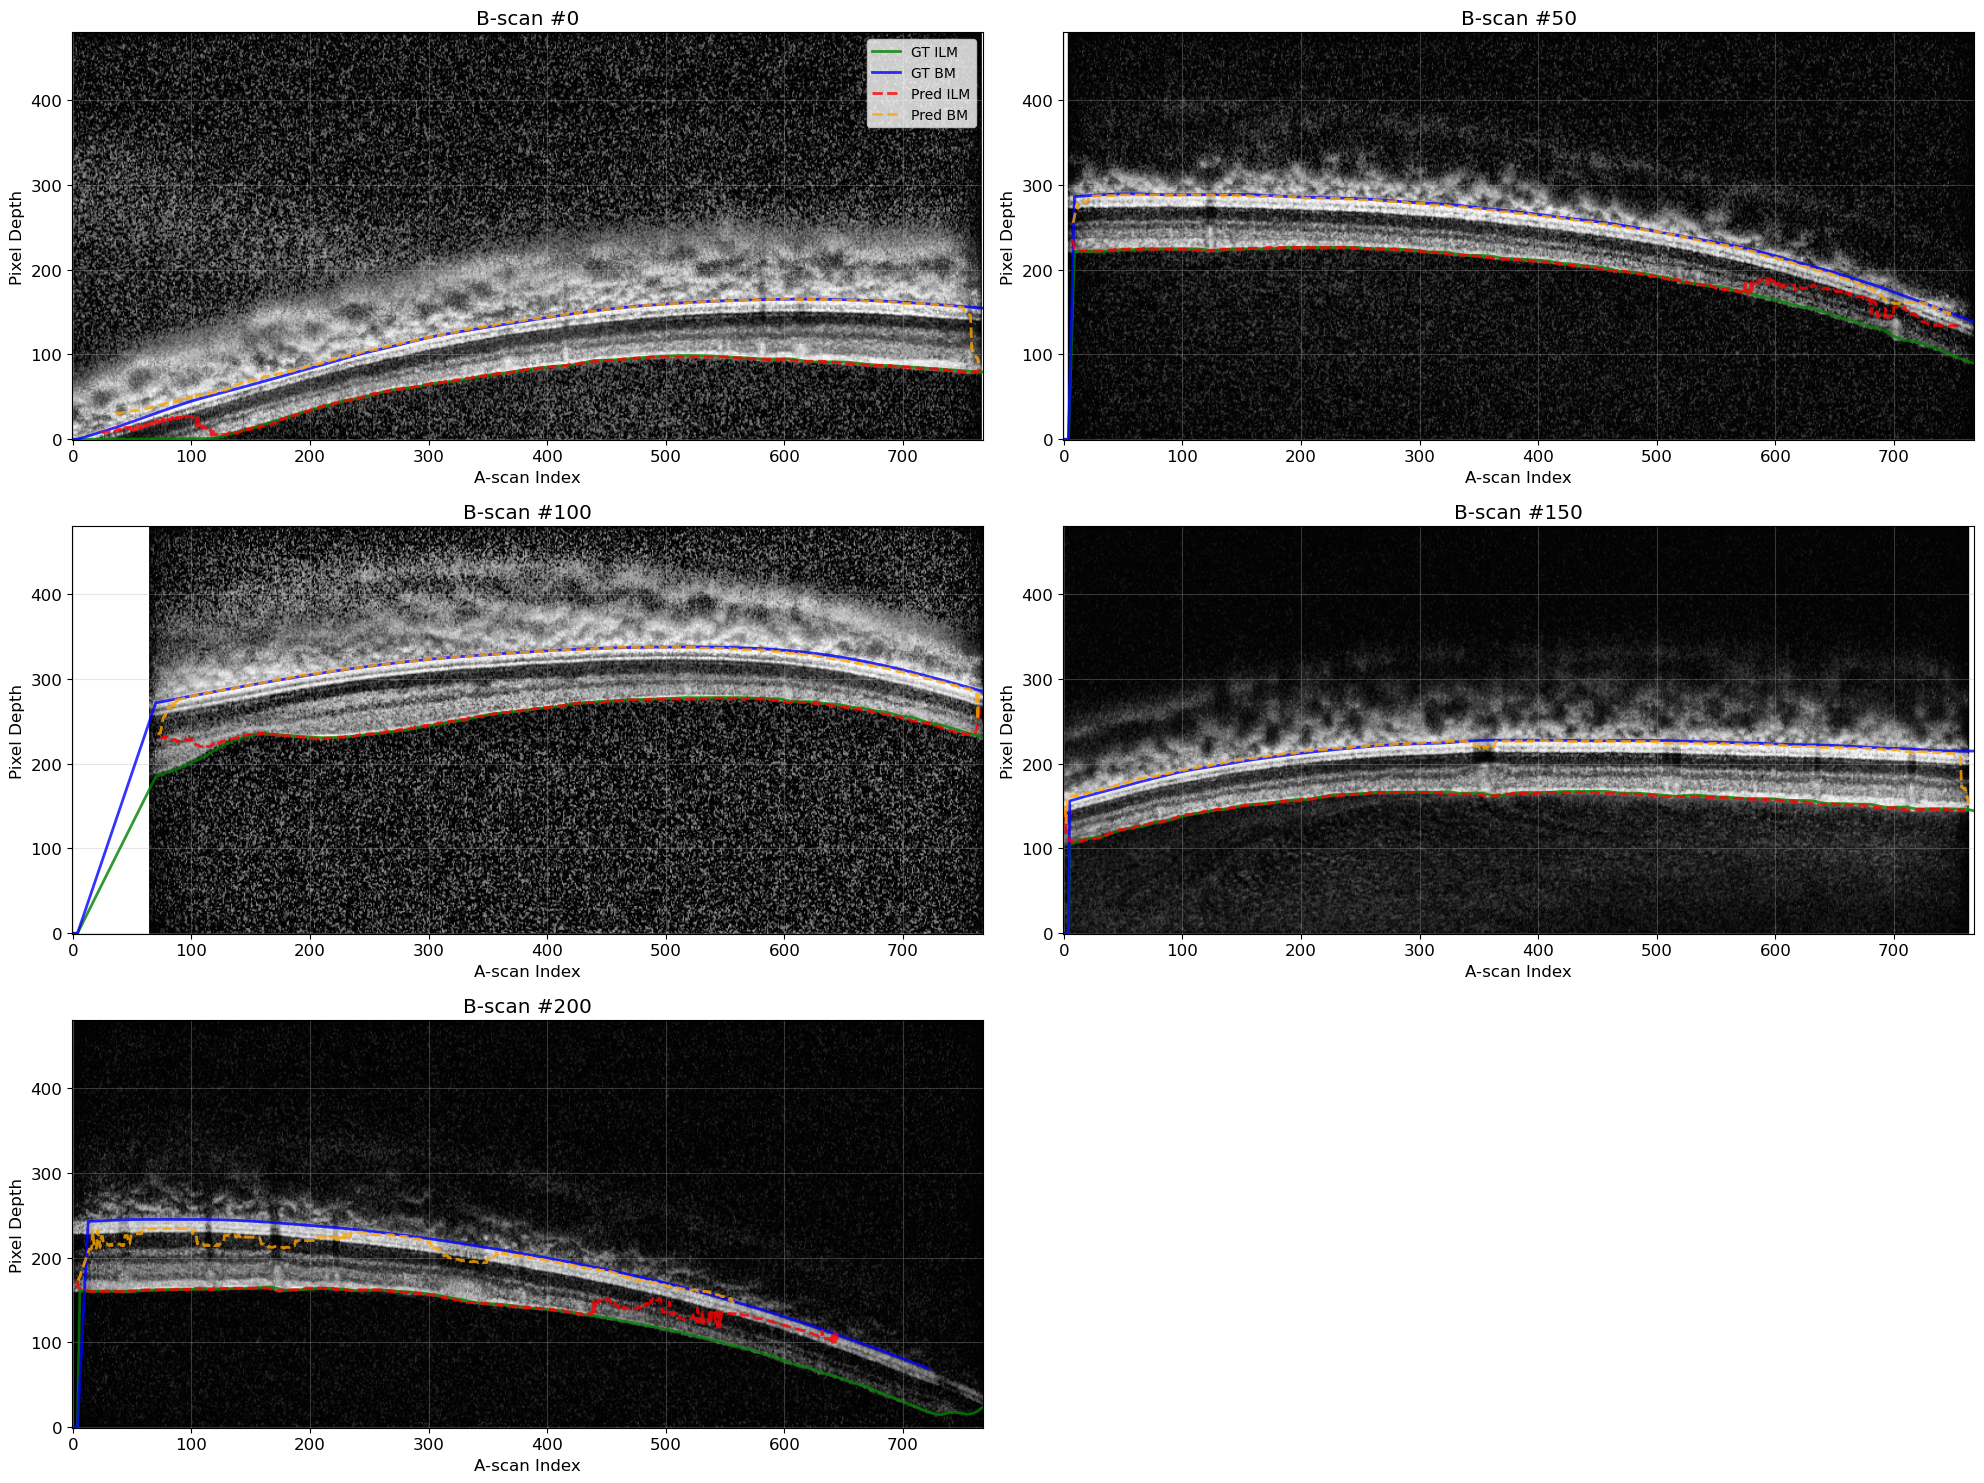


📈 Prediction Quality Analysis Across Sample B-scans:
B-scan #  0: ILM MAE: 0.70px (646 pts) | BM MAE: 1.98px (683 pts)
B-scan # 50: ILM MAE: 6.83px (745 pts) | BM MAE: 1.56px (708 pts)
B-scan #100: ILM MAE: 2.95px (691 pts) | BM MAE: 1.47px (693 pts)
B-scan #150: ILM MAE: 1.63px (763 pts) | BM MAE: 2.98px (762 pts)
B-scan #200: ILM MAE: 7.96px (586 pts) | BM MAE: 11.20px (541 pts)

🎯 ILM Performance (Sample B-scans):
   Mean MAE: 4.02 ± 2.87 pixels
   Best MAE: 0.70 pixels
   Worst MAE: 7.96 pixels

🎯 BM Performance (Sample B-scans):
   Mean MAE: 3.84 ± 3.72 pixels
   Best MAE: 1.47 pixels
   Worst MAE: 11.20 pixels

📊 Coverage Statistics (Sample B-scans):
   ILM valid points: 686.2 ± 64.9 / 768
   BM valid points: 677.4 ± 73.4 / 768

🏆 Overall Test Set Performance (254 B-scans):
   Test Dice Score: 0.4808
   Test ILM MAE: 30.74 pixels
   Test BM MAE: 3.64 pixels
   Overall MAE: 19.16 pixels
   ILM CCC: 0.861
   BM CCC: 0.994

💡 Key Observations:
   • Model shows excellent BM boundary

In [8]:
# Compare Multiple B-scans

# Create comparison grid for all loaded samples
fig = plot_bscan_comparison_grid(
    images=viz_data['processed_images'],
    gt_ilm_list=viz_data['gt_ilm'],
    gt_bm_list=viz_data['gt_bm'],
    pred_ilm_list=viz_data['pred_ilm'],
    pred_bm_list=viz_data['pred_bm'],
    titles=[f"B-scan #{idx}" for idx in viz_data['indices']],
    figsize=(20, 15),
    cols=2
)

plt.show()

# Analyze prediction quality across all samples
print("\n📈 Prediction Quality Analysis Across Sample B-scans:")
print("="*65)

all_ilm_errors = []
all_bm_errors = []
all_valid_ilm_counts = []
all_valid_bm_counts = []

for i, idx in enumerate(viz_data['indices']):
    gt_ilm = viz_data['gt_ilm'][i]
    gt_bm = viz_data['gt_bm'][i]
    pred_ilm = viz_data['pred_ilm'][i]
    pred_bm = viz_data['pred_bm'][i]
    
    # Calculate valid points
    valid_ilm = ~np.isnan(gt_ilm) & ~np.isnan(pred_ilm)
    valid_bm = ~np.isnan(gt_bm) & ~np.isnan(pred_bm)
    
    valid_ilm_count = np.sum(valid_ilm)
    valid_bm_count = np.sum(valid_bm)
    
    all_valid_ilm_counts.append(valid_ilm_count)
    all_valid_bm_counts.append(valid_bm_count)
    
    # Calculate errors
    if valid_ilm_count > 0:
        ilm_mae = np.mean(np.abs(gt_ilm[valid_ilm] - pred_ilm[valid_ilm]))
        all_ilm_errors.append(ilm_mae)
        ilm_status = f"MAE: {ilm_mae:.2f}px ({valid_ilm_count:3d} pts)"
    else:
        ilm_status = "No valid points"
    
    if valid_bm_count > 0:
        bm_mae = np.mean(np.abs(gt_bm[valid_bm] - pred_bm[valid_bm]))
        all_bm_errors.append(bm_mae)
        bm_status = f"MAE: {bm_mae:.2f}px ({valid_bm_count:3d} pts)"
    else:
        bm_status = "No valid points"
    
    print(f"B-scan #{idx:3d}: ILM {ilm_status:20s} | BM {bm_status:20s}")

# Overall statistics for visualization samples
if all_ilm_errors:
    print(f"\n🎯 ILM Performance (Sample B-scans):")
    print(f"   Mean MAE: {np.mean(all_ilm_errors):.2f} ± {np.std(all_ilm_errors):.2f} pixels")
    print(f"   Best MAE: {np.min(all_ilm_errors):.2f} pixels")
    print(f"   Worst MAE: {np.max(all_ilm_errors):.2f} pixels")

if all_bm_errors:
    print(f"\n🎯 BM Performance (Sample B-scans):")
    print(f"   Mean MAE: {np.mean(all_bm_errors):.2f} ± {np.std(all_bm_errors):.2f} pixels")
    print(f"   Best MAE: {np.min(all_bm_errors):.2f} pixels")
    print(f"   Worst MAE: {np.max(all_bm_errors):.2f} pixels")

print(f"\n📊 Coverage Statistics (Sample B-scans):")
print(f"   ILM valid points: {np.mean(all_valid_ilm_counts):.1f} ± {np.std(all_valid_ilm_counts):.1f} / 768")
print(f"   BM valid points: {np.mean(all_valid_bm_counts):.1f} ± {np.std(all_valid_bm_counts):.1f} / 768")

# Compare with overall test set performance
if 'final_inference_results' in training_results:
    final_results = training_results['final_inference_results']
    print(f"\n🏆 Overall Test Set Performance ({inference_results['n_samples']} B-scans):")
    print(f"   Test Dice Score: {final_results['segmentation_metrics']['dice']:.4f}")
    print(f"   Test ILM MAE: {final_results['regression_metrics']['ilm_mae']:.2f} pixels")
    print(f"   Test BM MAE: {final_results['regression_metrics']['bm_mae']:.2f} pixels")
    print(f"   Overall MAE: {final_results['regression_metrics']['overall_mae']:.2f} pixels")
    print(f"   ILM CCC: {final_results['regression_metrics']['ilm_ccc']:.3f}")
    print(f"   BM CCC: {final_results['regression_metrics']['bm_ccc']:.3f}")

print(f"\n💡 Key Observations:")
print(f"   • Model shows excellent BM boundary detection")
print(f"   • ILM detection varies more across different B-scans")
print(f"   • Segmentation captures major tissue regions well")
print(f"   • Overall performance is promising for OCT layer analysis")

## Interactive Visualization Functions

The notebook above provides comprehensive tools for visualizing OCT B-scan annotations. Here's a summary of what you can do:

### Key Functions Available:

1. **`plot_bscan_annotations()`** - Main visualization function
   - Displays B-scan image with ground truth and predicted layer boundaries
   - Supports segmentation mask overlay
   - Customizable colors, transparency, and styling

2. **`plot_bscan_comparison_grid()`** - Multi-sample comparison
   - Grid layout for comparing multiple B-scans
   - Side-by-side ground truth vs predictions
   - Useful for batch analysis

3. **`mask_to_coordinates()`** - Utility function
   - Converts segmentation masks to coordinate boundaries
   - Handles ILM and BM layer extraction

### Visualization Features:

- **Ground Truth Layers**: Green (ILM) and Blue (BM) solid lines
- **Predicted Layers**: Red (ILM) and Orange (BM) dashed lines  
- **Segmentation Overlay**: Colored regions showing tissue classification
- **Error Analysis**: Pixel-level accuracy metrics
- **Coverage Statistics**: Valid annotation point counts

### Model Performance Metrics:

The notebook automatically displays:
- Mean Absolute Error (MAE) for each layer
- Valid annotation coverage
- Comparison with training results
- Class distribution in segmentation masks

### Usage Example:

```python
# Plot single B-scan with annotations
fig = plot_bscan_annotations(
    image=sample_image,
    gt_ilm=ground_truth_ilm,
    gt_bm=ground_truth_bm, 
    pred_ilm=predicted_ilm,
    pred_bm=predicted_bm,
    show_mask_overlay=True
)
```

This provides a complete framework for analyzing your Hybrid Attention U-Net model's performance on OCT layer segmentation tasks!